# Do not change imports

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics.pairwise import cosine_similarity

from urllib.parse import urljoin
import itertools
import random

import matplotlib.pyplot as plt
%matplotlib inline

# A. MovieLens 100K Dataset: EDA via Pandas
Read the README (https://grouplens.org/datasets/movielens/100k/)

In [2]:
ML_100k_BASE_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/'

def movielens_url(fname):
    return urljoin(ML_100k_BASE_URL, fname)

## A.1. Read Genres

In [3]:
# names of the columns - see README, u.genre
genre_cols = ['genre', 'genre_id']

genres = pd.read_csv(movielens_url('u.genre'), sep='|', names=genre_cols)

genres

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


## A.2. Read Users

In [4]:
user_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

# read users from u.user
users = pd.read_csv(movielens_url('u.user'), sep='|', names=user_cols)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
sex           943 non-null object
occupation    943 non-null object
zip_code      943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


## A.3. Read Movies

In [5]:
# Be lazy - let the genre table tell you the last set of column names
movie_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL'] + [g for g in genres.sort_values(by='genre_id')['genre']]
 
#read movies from u.item
movies = pd.read_csv(movielens_url('u.item'), sep='|', names=movie_cols, encoding='latin-1')

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
movie_id              1682 non-null int64
movie_title           1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
IMDb_URL              1679 non-null object
unknown               1682 non-null int64
Action                1682 non-null int64
Adventure             1682 non-null int64
Animation             1682 non-null int64
Children's            1682 non-null int64
Comedy                1682 non-null int64
Crime                 1682 non-null int64
Documentary           1682 non-null int64
Drama                 1682 non-null int64
Fantasy               1682 non-null int64
Film-Noir             1682 non-null int64
Horror                1682 non-null int64
Musical               1682 non-null int64
Mystery               1682 non-null int64
Romance               1682 non-null int64
Sci-Fi                1682 non-null int64
Thriller 

In [6]:
# Interesting... find the row with a null release_date!
movies[pd.isnull(movies['release_date'])]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# assign movie_id (to check/clean up ratings later)
bad_row_id = 266

# drop the row (in place!)
movies.drop(movies.loc[pd.isnull(movies.release_date)].index, inplace=True)

# confirm it's gone
movies[pd.isnull(movies['release_date'])]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western


In [8]:
# output a table including only the movies with null IMDB urls
movies[pd.isnull(movies['IMDb_URL'])]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1357,1358,The Deadly Cure (1996),16-Sep-1996,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1358,1359,Boys in Venice (1996),24-Sep-1996,NaN,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# output all the fields of the first row
movies.loc[1357]

movie_id                                1358
movie_title           The Deadly Cure (1996)
release_date                     16-Sep-1996
video_release_date                       NaN
IMDb_URL                                 NaN
unknown                                    0
Action                                     1
Adventure                                  0
Animation                                  0
Children's                                 0
Comedy                                     0
Crime                                      0
Documentary                                0
Drama                                      0
Fantasy                                    0
Film-Noir                                  0
Horror                                     0
Musical                                    0
Mystery                                    0
Romance                                    0
Sci-Fi                                     0
Thriller                                   0
War       

Try finding this movie with Google (it does exist) - what is special/different about it?

I found the movie here at http://diedangerdiediekill.blogspot.com/2014/10/ill-buy-that-for-dollar-deadly-cure.html. But it wasn't available on IMDB which is correct since, IMDb url wasn't even present.

The film genres states as Action but in actual the movie looked more like an animated one because there is no way disguising its origins as a live action video

In [10]:
# output all the fields of the second row
movies.loc[1358]

movie_id                               1359
movie_title           Boys in Venice (1996)
release_date                    24-Sep-1996
video_release_date                      NaN
IMDb_URL                                NaN
unknown                                   0
Action                                    0
Adventure                                 0
Animation                                 0
Children's                                0
Comedy                                    0
Crime                                     0
Documentary                               0
Drama                                     1
Fantasy                                   0
Film-Noir                                 0
Horror                                    0
Musical                                   0
Mystery                                   0
Romance                                   0
Sci-Fi                                    0
Thriller                                  0
War                             

Try finding this movie with Google - comment on the likely name/origin of this movie.

The movie as expected wasn't present on IMDb. However I found some information on
http://movie-rs.com/boys-in-venice-1996/, which referred the movie name as Boys, which was present on IMDb.
The origin of the movies is in USA.

In [11]:
# there is one movie with an unknown genre - what is it?
movies[movies.unknown == 1]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1372,1373,Good Morning (1971),4-Feb-1971,NaN,http://us.imdb.com/M/title-exact?Good%20Mornin...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


find this movie using Google - what is special about it? what would you indicate as its genre?

 The movie is about comedy reflects some Californians' reactions during the Vietnam War.
 The genre mentioned is Short films while I guess, it could have been Comedy

In [12]:
# there is a field of the movies dataset that has no useful values - what is it?
bad_field = 'video_release_date'
movies.drop(bad_field, 1, inplace=True)

# It also turns out that the IMDB url's don't work :(
movies.drop('IMDb_URL', 1, inplace=True)

movies.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## A.4. Read Ratings

In [13]:
rating_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

# read ratings from u.data
ratings = pd.read_csv(movielens_url('u.data'), sep='\t', names=rating_cols)

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id           100000 non-null int64
movie_id          100000 non-null int64
rating            100000 non-null int64
unix_timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [14]:
# remember to drop ratings of our bad movie above
# ratings[ratings.movie_id == 266]
ratings.drop(ratings[ratings.movie_id == 267].index, inplace=True)
# confirm they are gone
ratings[ratings.movie_id == 267]

,user_id,movie_id,rating,unix_timestamp


## A.5. Merge Dataset

In [15]:
lens = pd.merge(pd.merge(movies, ratings), users)
lens.head()

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Thriller,War,Western,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,0,0,0,0,1,1,0,...,0,0,0,308,5,887736696,60,M,retired,95076


## A.6. Ask Interesting Questions

In [16]:
# compute sparsity = 100% * (# ratings) / ((# users) * (# movies))
#       basically: what percentage of the full utility matrix is represented?
count1 = ratings['rating'].count()
count2 = users['user_id'].count()
count3 = movies['movie_id'].count()
sparsity = (count1/(count2*count3)) * 100

print('Sparsity: {:.2f}%'.format(sparsity))


Sparsity: 6.31%


In [17]:
# Aggregate by movie_id, get stats on number (i.e. size) of ratings per movie
grouped = lens.groupby('movie_id')['rating'].count()
grouped.describe()

count    1681.000000
mean       59.483046
std        80.398338
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64

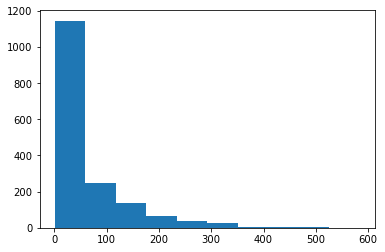

In [18]:
# Visualize the movie counts as a histogram
list = []
for id, rating in grouped.items():
    list.append(rating)
    
plt.hist(list)
plt.show()

In [19]:
# Aggregate by user_id, get stats on number (i.e. size) of ratings per user
grouped1 = lens.groupby('user_id')['rating'].count()
grouped1.describe()

count    943.000000
mean     106.034995
std      100.920992
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

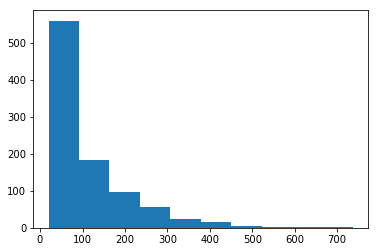

In [20]:
# Visualize the user counts as a histogram
list = []
for id, rating in grouped1.items():
    list.append(rating)
    
plt.hist(list)
plt.show()

comment on the last two stats tables/plots - what does this say in general about ratings per user/movie?

In the first plot, we an easily visualize, the amount of people who have not rated any partcular movie.
In the second plot, we can visualize, the amount of users who have been giving rating for the movies.

In [21]:
# Which movie has the most ratings?
most_rated = lens.groupby('movie_title').size().sort_values(ascending=False)[:1]

movieTitle = []

for index in most_rated.items():
    movieTitle.append(index[0])

movies[movies.movie_title == movieTitle[0]]

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,Star Wars (1977),01-Jan-1977,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


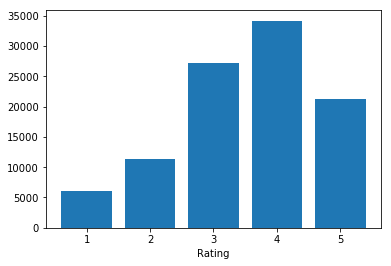

In [22]:
# are all ratings equally likely? output a bar chart of rating frequency overall
# ratingsUniq = ratings.rating.unique()
# ratingsUniq.sort()

ratingsUniq = ratings.rating.unique()
ratingsUniq.sort()

countVal = []


countPerRating = lens.groupby('rating').count()


for rating, count in countPerRating['movie_id'].items():
    countVal.append(count)
    
    
plt.bar(ratingsUniq,countVal)
plt.xlabel('Rating')
plt.show()

In [23]:
# of the movies that have 300 or more ratings, what are the top-ten ranked movies?
topmostMovies = lens.groupby(['movie_id','movie_title']).agg({'rating': [np.size, np.mean]})

top300 = topmostMovies['rating']['size'] >= 300

topmostMovies[top300].sort_values([('rating', 'mean')], ascending=False)[:10]

rating          
                                                  size      mean
movie_id movie_title                                            
50       Star Wars (1977)                          583  4.358491
98       Silence of the Lambs, The (1991)          390  4.289744
127      Godfather, The (1972)                     413  4.283293
174      Raiders of the Lost Ark (1981)            420  4.252381
313      Titanic (1997)                            350  4.245714
172      Empire Strikes Back, The (1980)           367  4.204360
173      Princess Bride, The (1987)                324  4.172840
100      Fargo (1996)                              508  4.155512
168      Monty Python and the Holy Grail (1974)    316  4.066456
56       Pulp Fiction (1994)                       394  4.060914

In [24]:
# describe one more interesting question, and then query the result with Pandas
#Question : Top rated Animation movies whose ratings are more than 3

lens1 = lens[lens.Animation == 1]
lens1
highest_rating = lens1.groupby(['movie_id', 'movie_title', 'rating']).agg({'rating': [np.size, np.mean]})
atleast_3 = highest_rating['rating']['mean'] >= 3
highest_rating[atleast_3].sort_values([('rating', 'mean')], ascending=False)[:20]


rating     
                                                              size mean
movie_id movie_title                                 rating            
473      James and the Giant Peach (1996)            5          10    5
588      Beauty and the Beast (1991)                 5          48    5
240      Beavis and Butt-head Do America (1996)      5          12    5
404      Pinocchio (1940)                            5          18    5
408      Close Shave, A (1995)                       5          70    5
418      Cinderella (1950)                           5          20    5
420      Alice in Wonderland (1951)                  5          12    5
422      Aladdin and the King of Thieves (1996)      5           1    5
426      Transformers: The Movie, The (1986)         5           2    5
432      Fantasia (1940)                             5          53    5
501      Dumbo (1941)                                5          21    5
538      Anastasia (1997)                            5           9    5
542      Pocahontas (1995)                           5           2    5
596      Hunchback of Notre Dame, The (1996)         5          18    5
189      Grand Day Out, A (1992)                     5          25    5
624      Three Caballeros, The (1945)                5           4    5
625      Sword in the Stone, The (1963)              5           6    5
820      Space Jam (1996)                            5           2    5
946      Fox and the Hound, The (1981)               5           7    5
969      Winnie the Pooh and the Blustery Day (1968) 5          21    5

# B. Extract Utility Matrix

In [25]:
def user_id_to_index(id):
    return id-1

def user_index_to_id(idx):
    return idx+1

# Accounts for the bad movie
def movie_id_to_index(id):
    return id-1 if id<bad_row_id else id-2

# Accounts for the bad movie
def movie_index_to_id(idx):
    return idx+1 if idx<(bad_row_id-1) else idx+2

In [26]:
num_users = ratings.user_id.unique().shape[0]
num_movies = ratings.movie_id.unique().shape[0]

utility = np.zeros((num_users, num_movies))

for idx,rating in ratings.iterrows():
    utility[user_id_to_index(rating.user_id), movie_id_to_index(rating.movie_id)] = rating.rating

# should match above!
sparsity = float(len(utility.nonzero()[0]))
sparsity /= (utility.shape[0] * utility.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 6.31%


# C. Evaluation via Mean Squared Error (MSE)

In [27]:
a = [1, 2, 3, 4, 5]
b = [1, 1, 4, 2, 10]
print("{:.4f}".format(mse(a, b)))

6.2000


Show the mathematical operations that reproduce the above result

$$ mse = \frac{(1-1)^{2} + (1-2)^{2} + (4-3)^{2} + (2-4)^{2} + (10-5)^{2}}{5} = 6.2000$$

In [28]:
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

u1 = np.array([[2, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 2]])
u2 = np.array([[3, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 7]])

print("{:.4f}".format(mse_utility(u1, u2)))

2.0000


Explain what operation is being performed. Include *why* it is appropriate in the context evaluating a recommender system, as well as performance implications.
The above operation performed in Mean Squared Error. The above operation is appropriate because we have an explicit input from user and we have a predicted data with us. Given, both the above, we can easily calculate how, faulty the predition had been. However, this approach would have a slight disadvantage, if we look in general aspect for a real dataset, where we might not have explicit input from user, there we would have a faulty value, which would not make a sense.  

Show the mathematical operations that reproduce the above result

$$ mse = \frac{(3-2)^{2}+(4-4)^{2}+(4-4)^{2}+(5-5)^{2}+(5-5)^{2}+(5-5)^{2}+(3-3)^{2}+(3-3)^{2}+(2-2)^{2}+(4-4)^{2}+(2-2)^{2}+(1-1)^{2}+(7-2)^{2}}{13} $$

$$ = \frac{26}{13}$$

$$= 2.0000$$


# D. Similarity via Cosine Distance

In [29]:
# implement, only use primitive Python loops/operations
#       sim = (A . B) / ( ||A|| ||B|| )
def cosine_sim(v1, v2):
    xx = 0
    xy = 0
    yy = 0
    for i in range(len(v1)):
        x = v1[i]
        y = v2[i]
        xx += x*x
        yy += y*y
        xy += x*y
    return xy/((xx*yy) ** (1/2))
    
v1 = [5, 0, 3, 0, 2, 0, 0, 2, 0, 0]
v2 = [3, 0, 2, 0, 1, 1, 0, 1, 0, 1]

print("Cosine Similarity: {:.6f}, expected={:.6f}".format(cosine_sim(v1, v2), cosine_similarity(np.array(v1).reshape(1, -1), np.array(v2).reshape(1, -1))[0][0]))

Cosine Similarity: 0.935601, expected=0.935601


In [30]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    print(step1)
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

print(sim_matrix(u1))
print(cosine_sim(u1[0], u1[1]))
print(cosine_sim(u1[0], u1[2]))
print(cosine_sim(u1[1], u1[2]))

[[ 36.  34.  16.]
 [ 34.  93.  49.]
 [ 16.  49.  29.]]
[[ 1.          0.58760596  0.49518757]
 [ 0.58760596  1.          0.94352977]
 [ 0.49518757  0.94352977  1.        ]]
0.587605960347
0.495187568472
0.943529768569


In [31]:
def sim_allpairs(u):
    n = u.shape[0]
    sim = np.eye(n)
    for x in itertools.combinations(range(n), 2):
        s = cosine_sim(u[x[0]], u[x[1]])
        sim[x[0], x[1]] = s
        sim[x[1], x[0]] = s
    
    return sim

print("MSE for U1: {:.4f}".format(mse_utility(sim_matrix(u1), sim_allpairs(u1))))
print("MSE for U2: {:.4f}".format(mse_utility(sim_matrix(u2), sim_allpairs(u2))))

[[ 36.  34.  16.]
 [ 34.  93.  49.]
 [ 16.  49.  29.]]
MSE for U1: 0.0000
[[ 41.  39.  38.]
 [ 39.  93.  64.]
 [ 38.  64.  74.]]
MSE for U2: 0.0000


In [32]:
%timeit -n 10 -r 3 sim_matrix(utility[:50,:])

[[ 3946.   319.    67. ...,   425.   923.   127.]
 [  319.   918.    75. ...,    96.   187.    38.]
 [   67.    75.   501. ...,    40.   134.    53.]
 ..., 
 [  425.    96.    40. ...,  1018.   186.     6.]
 [  923.   187.   134. ...,   186.  1885.   102.]
 [  127.    38.    53. ...,     6.   102.   345.]]
[[ 3946.   319.    67. ...,   425.   923.   127.]
 [  319.   918.    75. ...,    96.   187.    38.]
 [   67.    75.   501. ...,    40.   134.    53.]
 ..., 
 [  425.    96.    40. ...,  1018.   186.     6.]
 [  923.   187.   134. ...,   186.  1885.   102.]
 [  127.    38.    53. ...,     6.   102.   345.]]
[[ 3946.   319.    67. ...,   425.   923.   127.]
 [  319.   918.    75. ...,    96.   187.    38.]
 [   67.    75.   501. ...,    40.   134.    53.]
 ..., 
 [  425.    96.    40. ...,  1018.   186.     6.]
 [  923.   187.   134. ...,   186.  1885.   102.]
 [  127.    38.    53. ...,     6.   102.   345.]]
[[ 3946.   319.    67. ...,   425.   923.   127.]
 [  319.   918.    75. ...

In [33]:
%timeit -n 10 -r 3 sim_allpairs(utility[:50,:])

10 loops, best of 3: 4.48 s per loop


TODO:
1. Explain what each line of sim_matrix is doing (including why eps is necessary)
Step1 - Dot Product of matrix with it's transpose. Then we further add eps to normalize the data so that we donot ever do division by zero.
Step2 - Take diagonal of the matrix and make an array of each of the values.
Step 3- We normalize data by dividing matrix from step 1 by step 2 produced array and transpose produced by step
2. Explain why this approach is preferable to pairwise calls to cosine_sim (reference the previous two timeit calls; explain what each is doing and how it relates to your conclusion)
    
Sim_matrix is preferable as seen from the timeit functions above. The cells tells the average time for each loop. So based on this, we can see which is faster approach.

In [34]:
def sim_users(u):
    return sim_matrix(u)

# use sim_matrix to return similarity between items (i.e. movies)
def sim_items(u):
    return sim_matrix(u.T)

print(sim_items(u1))
print(cosine_sim(u1[:, 0], u1[:, 1]))
print(cosine_sim(u1[:, 0], u1[:, 2]))
print(cosine_sim(u1[:, 0], u1[:, 3]))
print(cosine_sim(u1[:, 0], u1[:, 4]))
print(cosine_sim(u1[:, 1], u1[:, 2]))
print(cosine_sim(u1[:, 1], u1[:, 3]))
print(cosine_sim(u1[:, 1], u1[:, 4]))
print(cosine_sim(u1[:, 2], u1[:, 3]))
print(cosine_sim(u1[:, 2], u1[:, 4]))
print(cosine_sim(u1[:, 3], u1[:, 4]))

[[ 33.  33.  29.  25.  27.]
 [ 33.  41.  33.  19.  23.]
 [ 29.  33.  29.  17.  19.]
 [ 25.  19.  17.  26.  27.]
 [ 27.  23.  19.  27.  29.]]
[[ 1.          0.89714996  0.93743687  0.85348593  0.87278605]
 [ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
 [ 0.93743687  0.9570244   1.          0.61910348  0.65517241]
 [ 0.85348593  0.5819357   0.61910348  1.          0.983282  ]
 [ 0.87278605  0.66701701  0.65517241  0.983282    1.        ]]
0.897149958915
0.937436866561
0.853485927499
0.872786048178
0.957024404433
0.58193569724
0.667017009151
0.61910348462
0.655172413793
0.983282004984


# E. K-Neighborhood

In [35]:
#       given a slice from a similarity matrix (arr),
#       index of "self" (self_idx),
#       and k
#       return dictionary of k most similar indexes as {idx:sim}
#       HINT: look at np.argsort
def top_k(arr, self_idx, k):
    r = {}
    val = np.argsort(-arr)[1:][:k]
    index = np.sort(val)
    for i in index:
        r[i] = arr[i]
    return r

In [36]:
sim_u1 = sim_items(u1)

# Example via u1...
print(sim_u1)
print()

# Top-2 w.r.t. row 0 (should be {1: 0.897, 2:0.937})
print(sim_u1[0])
print(top_k(sim_u1[0], 0, 2))
print()

# Top-2 w.r.t. row 1 (should be {0: 0.897, 2:0.957})
print(sim_u1[1])
print(top_k(sim_u1[1], 1, 2))
print()

# Top-3 w.r.t. col 1 (should be {0: 0.897, 2:0.957, 4:0.667})
print(sim_u1[:, 1])
print(top_k(sim_u1[:, 1], 1, 3))
print()

[[ 33.  33.  29.  25.  27.]
 [ 33.  41.  33.  19.  23.]
 [ 29.  33.  29.  17.  19.]
 [ 25.  19.  17.  26.  27.]
 [ 27.  23.  19.  27.  29.]]
[[ 1.          0.89714996  0.93743687  0.85348593  0.87278605]
 [ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
 [ 0.93743687  0.9570244   1.          0.61910348  0.65517241]
 [ 0.85348593  0.5819357   0.61910348  1.          0.983282  ]
 [ 0.87278605  0.66701701  0.65517241  0.983282    1.        ]]

[ 1.          0.89714996  0.93743687  0.85348593  0.87278605]
{1: 0.89714995891726312, 2: 0.93743686656305114}

[ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
{0: 0.89714995891726301, 2: 0.95702440443430259}

[ 0.89714996  1.          0.9570244   0.5819357   0.66701701]
{0: 0.89714995891726312, 2: 0.9570244044343027, 4: 0.66701700915996875}



# F. Recommend via Similar Users

In [37]:
#       given utility matrix (m_utility),
#       similarity of users (m_sim_users),
#       user index of interest (user_idx),
#       item index of interest (item_idx),
#       neighborhood size (k)
# 
#       output the average of the similarity-weighted ratings
#       of top-k similar users that have
#       rated the item
def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    similar = top_k(m_sim_users[user_idx],1,k)
    val1, val2 = 0, 0
    for val, ind in similar.items():
        if m_utility[val][item_idx] != 0:
            val1 += m_utility[val][item_idx]*ind
            val2 += ind
    if val2 == 0:
        return 0
    return val1/val2

 
print(u1)
print()
print(sim_users(u1))
print()

# Expected: 5
print(rec_via_users(u1, sim_users(u1), 0, 1, 1))

# Expected: 4.54 ~ (.588 * 5) + (.495 * 4) / (.588 + .495)
print(rec_via_users(u1, sim_users(u1), 0, 1, 2))

[[2 0 0 4 4]
 [5 5 5 3 3]
 [2 4 2 1 2]]

[[ 36.  34.  16.]
 [ 34.  93.  49.]
 [ 16.  49.  29.]]
[[ 1.          0.58760596  0.49518757]
 [ 0.58760596  1.          0.94352977]
 [ 0.49518757  0.94352977  1.        ]]

[[ 36.  34.  16.]
 [ 34.  93.  49.]
 [ 16.  49.  29.]]
5.0
[[ 36.  34.  16.]
 [ 34.  93.  49.]
 [ 16.  49.  29.]]
4.542675907


## F.1. Evaluation

In [38]:
random.seed(12345)

def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_users = sim_users(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

[[ 3946.   319.    67. ...,   182.   421.  1183.]
 [  319.   918.    75. ...,    95.   201.   151.]
 [   67.    75.   501. ...,    44.   115.    28.]
 ..., 
 [  182.    95.    44. ...,   377.    76.    87.]
 [  421.   201.   115. ...,    76.  1483.   331.]
 [ 1183.   151.    28. ...,    87.   331.  2219.]]
1/50 5.84188614857
2/50 3.87129290082
3/50 2.91131117606
4/50 2.39786489562
5/50 2.33668038893
6/50 2.29285870216
7/50 1.89375750256
8/50 1.70446310169
9/50 1.78996556778
10/50 1.61943756033
11/50 1.61818014506
12/50 1.55805663042
13/50 1.49220917799
14/50 1.51539060955
15/50 1.5083025828
16/50 1.51548471682
17/50 1.31980276463
18/50 1.26750910243
19/50 1.56929656118
20/50 1.35218404768
21/50 1.28806841872
22/50 1.42067451589
23/50 1.44442499546
24/50 1.32186364595
25/50 1.29177078834
26/50 1.23273657277
27/50 1.28052270113
28/50 1.14798250835
29/50 1.27765425224
30/50 1.26507296453
31/50 1.28067822578
32/50 1.2866915989
33/50 1.23598087875
34/50 1.34106350204
35/50 1.16582180593
36/

In [39]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 2, 100)

10 loops, best of 3: 1.41 s per loop


In [40]:
%timeit -n 10 -r 3 recs_via_users(utility, similarity_users, 20, 100)

10 loops, best of 3: 1.92 s per loop


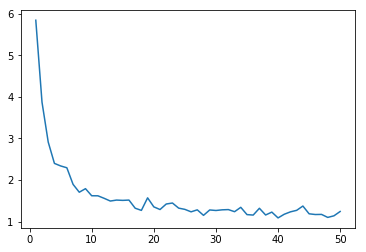

In [41]:
plt.plot(ks, mses)

TODO:
1. Describe what is being done in the recs_via_users function - what is the evaluation approach? What would have been a more "fair" methodology?

recs_via_users computes MSE on predicted values and actual values of ratings, parametrized by k neighbourhood.

2. What do you notice happening as k increases?
As k increases, MSE decreases. Thus, we can improve efficiency by increasing k.

3. Based upon these results, what is a reasonable neighborhood size?
I presume it should be 5.

# G. Recommend via SVD

In [42]:
random.seed(12345)

# TODO: given a utility matrix and
#       number of singular values to use
# 
#       return a projected matrix
#       based upon a limited number of dimensions
#       U_pred = U S V^T
# 
#       HINT: the svds function does most of the work for you
def svd_projection(m_utility, num_dims):
    U, s, Vt = svds(m_utility, num_dims)
    sig = np.diag(s)
    return np.dot(np.dot(U, sig), Vt)

def recs_via_svd(m_utility, num_dims, test_n):
    test = random.sample(range(m_utility.shape[0]), test_n)    
    svd_utility = svd_projection(utility, num_dims)
    
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                p = round(svd_utility[user_idx][item_idx])
                
                if p != 0:
                    pred.append(p)
                else:
                    pred.append(1.0e-9)

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
    
ds = []
mses = []
for i in range(100):
    ds.append(i+1)
    mses.append(recs_via_svd(utility, i+1, 100))
    print("{}/100".format(i+1), mses[-1])

1/100 7.74766354926
2/100 6.61237920534
3/100 6.69763432482
4/100 5.93433210613
5/100 6.09709810095
6/100 6.37813933048
7/100 5.42997198776
8/100 5.36756517801
9/100 5.44997540477
10/100 5.43615989563
11/100 4.78976906719
12/100 5.36239559898
13/100 5.68036285922
14/100 4.89012273445
15/100 4.95184501772
16/100 5.26490466983
17/100 4.58448533867
18/100 5.01692011056
19/100 4.47608657637
20/100 4.92642140397
21/100 4.61003337434
22/100 4.62991418802
23/100 4.31288289796
24/100 4.97574267935
25/100 4.27901766423
26/100 4.44226579459
27/100 4.31276230386
28/100 4.29616378388
29/100 4.37279970289
30/100 4.3050115201
31/100 4.00660982789
32/100 3.91708473899
33/100 4.14625850284
34/100 3.9348672881
35/100 3.94647306416
36/100 4.05445544497
37/100 3.70839226729
38/100 3.77391538615
39/100 4.0584037759
40/100 3.78175781887
41/100 3.89878577571
42/100 3.60881849267
43/100 3.66613513997
44/100 3.441199478
45/100 3.61559256954
46/100 3.55417040315
47/100 3.48873072322
48/100 3.84010869515
49/100

In [43]:
%timeit -n 10 -r 3 recs_via_svd(utility, 10, 100)

10 loops, best of 3: 768 ms per loop


In [44]:
%timeit -n 10 -r 3 recs_via_svd(utility, 20, 100)

The slowest run took 427.00 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 788 ms per loop


In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 40, 100)

10 loops, best of 3: 832 ms per loop


In [ ]:
%timeit -n 10 -r 3 recs_via_svd(utility, 80, 100)

In [ ]:
plt.plot(ds, mses)

TODO: comment on the relative speed/quality of the SVD approach as compared to the neighborhood approach
From above timeit cells loops, we can see SVD is really faster than the neighborhood approach. Hence, SVD works better.

# H. TODO: Your Turn
The previous sections explored some building blocks and methods of recommendation for the MovieLens dataset.
In this section, you must extend this work:
1. Implement a method that was not covered above (e.g. item-based neighborhood, direct matrix factorization) OR extend a method (e.g. incorporate rating bias)
2. Evaluate your method similar to what was done above

Do NOT change any code above - only add code/comment in this section (as many cells as you see fit). You are welcome to copy-paste code from above.

In [ ]:
def rec_via_items(m_utility, sim_item_matrix, user_idx, item_idx, k):
    similar = top_k(sim_item_matrix[item_idx], 1, k)
    val1, val2 = 0, 0
    for  val, ind in similar.items():
        if m_utility[user_idx][val]!=0:
            val1 += m_utility[user_idx][val] * ind
            val2 += ind
    if val2 == 0:
        return 0
    return val1/val2

print(u1)
print()
print(sim_items(u1))

In [ ]:
random.seed(12345)

def recs_via_items(m_utility, m_sim_items, k, test_n):
    test = random.sample(range(m_sim_items.shape[0]), test_n)
    true = []
    pred = []
    for item_idx in test:
        for user_idx in range(m_utility.shape[0]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                p = round(rec_via_items(m_utility, m_sim_items, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_items = sim_items(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_items(utility, similarity_items, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

In [ ]:
plt.plot(ks, mses)

# I. Extra Credit
If you so choose, create an actual recommendation engine using one of the supplied methods:
1. Create a function that takes as input a dictionary of {movie_title:rating}, as well as a k, and your function should return the top k movies that have not been watched and have highest predicted ratings.
2. Run the function on a few representative examples - analyze your results.